In [34]:
import xml.etree.ElementTree as ET
import itertools
import re
import nltk.data
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [30]:
#get all data loaded and sorted

data = []
target = []
test_data = []
test_target = []
categories = ["current", "past", "non", "unknown"]
def parsetrain(filename):
    tree = ET.parse(filename)
    #this filename can be changed to accommodate different smoker files
    root = tree.getroot()

    for element in root.findall('RECORD'):
        text = str(element.find('TEXT').text)[50:]
        data.append(text)
        s= str(element.find("SMOKING").attrib['STATUS'])
        if "UNK" in s:
            target.append(4)
        elif "NON" in s:
            target.append(3)
        elif "PAST" in s:
            target.append(2)
        else:
            target.append(1)
            
def parsetest(filename):
    tree = ET.parse(filename)
    #this filename can be changed to accommodate different smoker files
    root = tree.getroot()

    for element in root.findall('RECORD'):
        text = str(element.find('TEXT').text)[50:]
        test_data.append(text)
        s= str(element.find("SMOKING").attrib['STATUS'])
        if "UNK" in s:
            test_target.append(4)
        elif "NON" in s:
            test_target.append(3)
        elif "PAST" in s:
            test_target.append(2)
        else:
            test_target.append(1)
parsetrain('smokers_surrogate_train_all_version2.xml')
parsetest('smokers_surrogate_test_all_groundtruth_version2.xml')
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    sns.heatmap(cm)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [31]:
train_data = []
train_target = []
for i in range(0,len(data)):
    tar = target[i]
    sents = tokenizer.tokenize(data[i])
    train_target.extend([tar]*len(sents))
    train_data.extend(sents)
    
tst_data = []
tst_target = []
for i in range(0,len(test_data)):
    ttar = test_target[i]
    sents = tokenizer.tokenize(test_data[i])
    tst_target.extend([ttar]*len(sents))
    tst_data.extend(sents)

0.38990990991
Normalized confusion matrix
[[ 0.03222342  0.03329753  0.08163265  0.8528464 ]
 [ 0.03202479  0.0268595   0.11260331  0.8285124 ]
 [ 0.02594514  0.0289103   0.11119348  0.83395107]
 [ 0.02215465  0.0269331   0.10034752  0.85056473]]


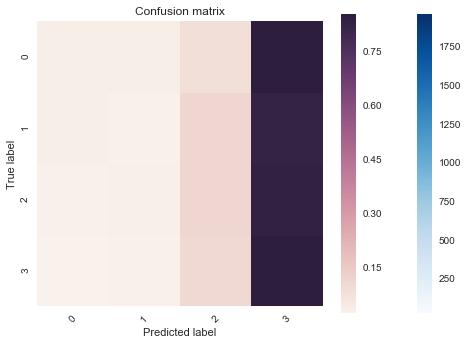

In [38]:
text_clf = Pipeline([('vect', CountVectorizer(max_df=0.95, min_df=2, stop_words='english', ngram_range=(2,4))),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(n_iter=100)),
])
_ = text_clf.fit(train_data, train_target)
predicted = text_clf.predict(tst_data)
print(np.mean(predicted == tst_target))
plot_confusion_matrix(confusion_matrix(tst_target,predicted),classes=[1,2,3,4],normalize=True)